In [53]:
import os

def load_oumvlp_gei_data(dataset_path):
    """
    Load OUMVLP GEI dataset for first 100 subjects.
    Splits into train and test based on folders ending with '-00' (train) and '-01' (test).
    Includes all view angles available in those folders.
    
    Args:
        dataset_path (str): Root path to OUMVLP GEI dataset folder.
        
    Returns:
        train_data (list): List of dicts for training sequences.
        test_data (list): List of dicts for testing sequences.
    """
    subjects = [f"{i:05d}" for i in range(1, 101)]  # First 100 subjects: 00001 to 00100
    
    folders = sorted(os.listdir(dataset_path))
    train_folders = [f for f in folders if f.endswith('-00') and (f.startswith('090') or f.startswith('270'))]
    test_folders = [f for f in folders if f.endswith('-01') and (f.startswith('090') or f.startswith('270'))]

    
    train_data = []
    test_data = []
    
    def collect_data(folders_list, label):
        data = []
        for folder in folders_list:
            folder_path = os.path.join(dataset_path, folder)
            if not os.path.isdir(folder_path):
                continue
            
            # List all png files (subjects), filter by first 100 subjects
            files = [f for f in os.listdir(folder_path) if f.endswith('.png') and f[:-4] in subjects]
            files.sort()
            
            # The folder name convention [angle]-[00/01], get angle from folder name
            angle = folder.split('-')[0]
            
            for file in files:
                subject_id = file[:-4]  # Remove .png
                full_path = os.path.join(folder_path, file)
                
                data.append({
                    'subject': subject_id,
                    'folder': folder,
                    'angle': angle,
                    'path': full_path,
                    'set': label
                })
        return data
    
    train_data = collect_data(train_folders, 'train')
    test_data = collect_data(test_folders, 'test')
    
    print(f"Loaded {len(train_data)} training samples from OUMVLP (first 100 subjects)")
    print(f"Loaded {len(test_data)} testing samples from OUMVLP (first 100 subjects)")
    
    return train_data, test_data


In [54]:
train_data, test_data = load_oumvlp_gei_data(r'D:\vit study\Machine Learning\Gait\GEI\GEI')

Loaded 199 training samples from OUMVLP (first 100 subjects)
Loaded 196 testing samples from OUMVLP (first 100 subjects)


In [55]:
train_data[1]

{'subject': '00002',
 'folder': '090-00',
 'angle': '090',
 'path': 'D:\\vit study\\Machine Learning\\Gait\\GEI\\GEI\\090-00\\00002.png',
 'set': 'train'}

In [56]:
from collections import Counter

def count_images_per_angle(data):
    """
    Count number of images per angle from the dataset list.
    
    Args:
        data (list): List of dicts with 'angle' key.
        
    Returns:
        dict: Angle as key, count of images as value.
    """
    angle_counts = Counter()
    for item in data:
        angle_counts[item['angle']] += 1
    return dict(angle_counts)

# Assuming train_data and test_data are loaded
train_counts = count_images_per_angle(train_data)
test_counts = count_images_per_angle(test_data)

print("Number of images per angle in TRAIN set:")
for angle, count in sorted(train_counts.items()):
    print(f"Angle {angle}: {count}")

print("\nNumber of images per angle in TEST set:")
for angle, count in sorted(test_counts.items()):
    print(f"Angle {angle}: {count}")


Number of images per angle in TRAIN set:
Angle 090: 99
Angle 270: 100

Number of images per angle in TEST set:
Angle 090: 99
Angle 270: 97


In [57]:
from collections import Counter

def count_images_per_subject(data):
    """
    Count number of images per subject from dataset list.

    Args:
        data (list): List of dicts with 'subject' key.

    Returns:
        dict: Subject ID as key, count of images as value.
    """
    subject_counts = Counter()
    for item in data:
        subject_counts[item['subject']] += 1
    return dict(subject_counts)

# Count images per subject for train and test data
train_subject_counts = count_images_per_subject(train_data)
test_subject_counts = count_images_per_subject(test_data)

# Display results
print("Train set image counts per subject:")
for subject, count in sorted(train_subject_counts.items()):
    print(f"Subject {subject}: {count} images")

print("\nTest set image counts per subject:")
for subject, count in sorted(test_subject_counts.items()):
    print(f"Subject {subject}: {count} images")


Train set image counts per subject:
Subject 00001: 2 images
Subject 00002: 2 images
Subject 00003: 2 images
Subject 00004: 2 images
Subject 00005: 2 images
Subject 00006: 2 images
Subject 00007: 2 images
Subject 00008: 2 images
Subject 00009: 2 images
Subject 00010: 2 images
Subject 00011: 2 images
Subject 00012: 2 images
Subject 00013: 2 images
Subject 00014: 2 images
Subject 00015: 2 images
Subject 00016: 1 images
Subject 00017: 2 images
Subject 00018: 2 images
Subject 00019: 2 images
Subject 00020: 2 images
Subject 00021: 2 images
Subject 00022: 2 images
Subject 00023: 2 images
Subject 00024: 2 images
Subject 00025: 2 images
Subject 00026: 2 images
Subject 00027: 2 images
Subject 00028: 2 images
Subject 00029: 2 images
Subject 00030: 2 images
Subject 00031: 2 images
Subject 00032: 2 images
Subject 00033: 2 images
Subject 00034: 2 images
Subject 00035: 2 images
Subject 00036: 2 images
Subject 00037: 2 images
Subject 00038: 2 images
Subject 00039: 2 images
Subject 00040: 2 images
Subj

In [58]:
from collections import defaultdict

def filter_and_limit_images_priority(data, min_images=2, limit=2):
    """
    Filter out subjects with fewer than min_images.
    Limit images per subject to exactly 'limit', prioritizing removal
    of angles '000' and '180' first.
    """
    # Group images by subject
    subject_images = defaultdict(list)
    for item in data:
        subject_images[item['subject']].append(item)

    filtered_data = []

    for subject, items in subject_images.items():
        if len(items) < min_images:
            continue  # drop subjects with too few images

        # Partition items by priority removal angles and others
        angle_priority = [i for i in items if i['angle'] in ('000', '180')]
        angle_other    = [i for i in items if i['angle'] not in ('000', '180')]

        # Start with all images
        kept = items.copy()

        # Calculate how many must be removed
        to_remove = len(kept) - limit

        # Remove from priority angles first
        while to_remove > 0 and angle_priority:
            rm = angle_priority.pop(0)  # remove earliest priority item
            kept.remove(rm)
            to_remove -= 1

        # If still need to remove more, remove from other angles
        while to_remove > 0 and angle_other:
            rm = angle_other.pop(0)
            kept.remove(rm)
            to_remove -= 1

        # Now kept has exactly 'limit' items
        filtered_data.extend(kept)

    return filtered_data

# Apply to train and test sets
train_filtered = filter_and_limit_images_priority(train_data, min_images=2, limit=2)
test_filtered  = filter_and_limit_images_priority(test_data,  min_images=2, limit=2)

print(f"Train samples after priority filtering: {len(train_filtered)}")
print(f"Test samples after priority filtering:  {len(test_filtered)}")


Train samples after priority filtering: 198
Test samples after priority filtering:  194


In [59]:
from collections import Counter

def count_images_per_subject(data):
    """
    Count number of images per subject from dataset list.

    Args:
        data (list): List of dicts with 'subject' key.

    Returns:
        dict: Subject ID as key, count of images as value.
    """
    subject_counts = Counter()
    for item in data:
        subject_counts[item['subject']] += 1
    return dict(subject_counts)

# Count images per subject for train and test data
train_subject_counts = count_images_per_subject(train_filtered)
test_subject_counts = count_images_per_subject(test_filtered)

# Display results
print("Train set image counts per subject:")
for subject, count in sorted(train_subject_counts.items()):
    print(f"Subject {subject}: {count} images")

print("\nTest set image counts per subject:")
for subject, count in sorted(test_subject_counts.items()):
    print(f"Subject {subject}: {count} images")


Train set image counts per subject:
Subject 00001: 2 images
Subject 00002: 2 images
Subject 00003: 2 images
Subject 00004: 2 images
Subject 00005: 2 images
Subject 00006: 2 images
Subject 00007: 2 images
Subject 00008: 2 images
Subject 00009: 2 images
Subject 00010: 2 images
Subject 00011: 2 images
Subject 00012: 2 images
Subject 00013: 2 images
Subject 00014: 2 images
Subject 00015: 2 images
Subject 00017: 2 images
Subject 00018: 2 images
Subject 00019: 2 images
Subject 00020: 2 images
Subject 00021: 2 images
Subject 00022: 2 images
Subject 00023: 2 images
Subject 00024: 2 images
Subject 00025: 2 images
Subject 00026: 2 images
Subject 00027: 2 images
Subject 00028: 2 images
Subject 00029: 2 images
Subject 00030: 2 images
Subject 00031: 2 images
Subject 00032: 2 images
Subject 00033: 2 images
Subject 00034: 2 images
Subject 00035: 2 images
Subject 00036: 2 images
Subject 00037: 2 images
Subject 00038: 2 images
Subject 00039: 2 images
Subject 00040: 2 images
Subject 00041: 2 images
Subj

In [60]:
# Get sets of subjects in train and test
train_subjects_set = set([item['subject'] for item in train_filtered])
test_subjects_set = set([item['subject'] for item in test_filtered])

# Find common subjects present in both
common_subjects = train_subjects_set.intersection(test_subjects_set)

# Filter train and test data to keep only common subjects
train_filtered_common = [item for item in train_filtered if item['subject'] in common_subjects]
test_filtered_common = [item for item in test_filtered if item['subject'] in common_subjects]

print(f"Subjects in TRAIN after filtering: {len(set([item['subject'] for item in train_filtered_common]))}")
print(f"Subjects in TEST after filtering: {len(set([item['subject'] for item in test_filtered_common]))}")


Subjects in TRAIN after filtering: 97
Subjects in TEST after filtering: 97


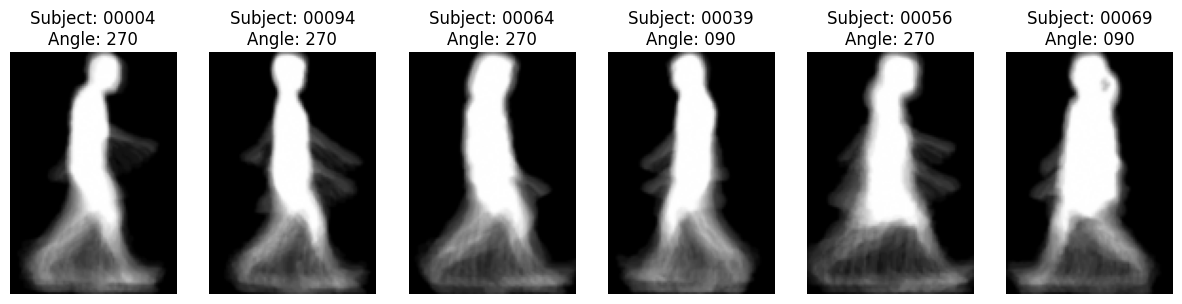

In [61]:
import matplotlib.pyplot as plt
from PIL import Image

def visualize_samples(data, num_samples=6):
    """
    Visualize sample images from the dataset.
    
    Args:
        data (list): List of dicts containing 'path', 'subject', 'angle'.
        num_samples (int): Number of random samples to display.
    """
    import random
    samples = random.sample(data, num_samples)
    
    plt.figure(figsize=(15, 5))
    for i, sample in enumerate(samples):
        img = Image.open(sample['path'])
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Subject: {sample['subject']}\nAngle: {sample['angle']}")
        plt.axis('off')
    plt.show()

# Visualize 6 random train samples
visualize_samples(train_filtered_common, num_samples=6)


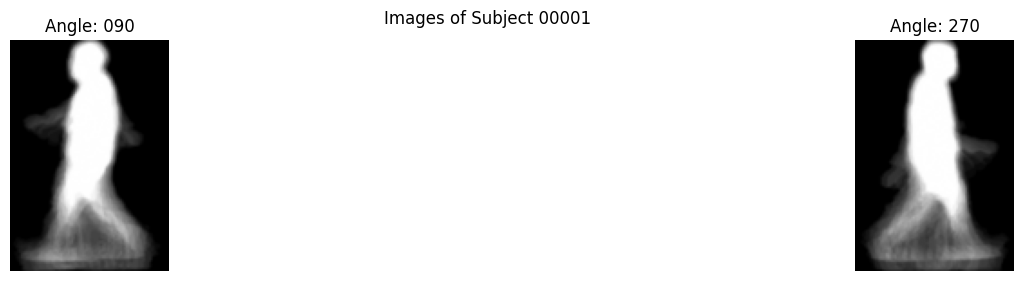

In [62]:
def visualize_subject_images(data, subject_id, max_images=2):
    """
    Show multiple images of a single subject in a grid.
    
    Args:
        data (list): Dataset list of dicts with 'subject' and 'path'.
        subject_id (str): Subject ID to visualize (e.g., '00001').
        max_images (int): Number of images to show.
    """
    subject_images = [item for item in data if item['subject'] == subject_id]
    subject_images = subject_images[:max_images]
    
    plt.figure(figsize=(20, 3))
    for i, item in enumerate(subject_images):
        img = Image.open(item['path'])
        plt.subplot(1, max_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Angle: {item['angle']}")
        plt.axis('off')
    plt.suptitle(f"Images of Subject {subject_id}")
    plt.show()

# Visualize images of subject '00001'
visualize_subject_images(train_filtered_common, '00001')


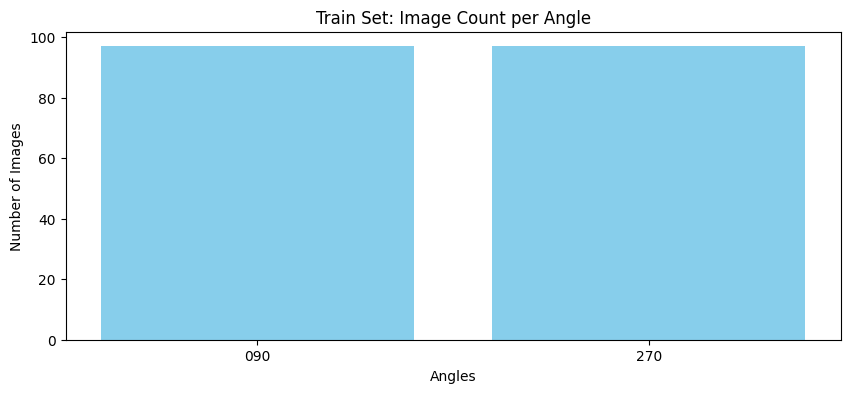

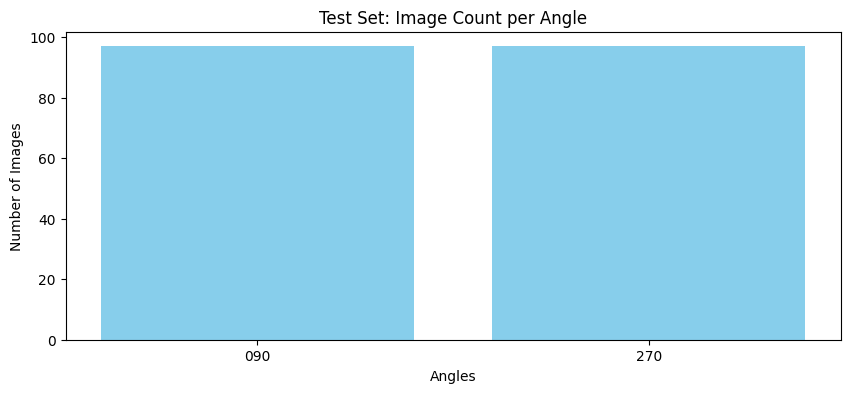

In [63]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_angle_distribution(data, title="Image Count per Angle"):
    angles = [item['angle'] for item in data]
    counts = Counter(angles)
    
    angles_sorted = sorted(counts.keys())
    values = [counts[angle] for angle in angles_sorted]
    
    plt.figure(figsize=(10, 4))
    plt.bar(angles_sorted, values, color='skyblue')
    plt.xlabel("Angles")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.show()

# Plot for train set
plot_angle_distribution(train_filtered_common, title="Train Set: Image Count per Angle")

# Plot for test set
plot_angle_distribution(test_filtered_common, title="Test Set: Image Count per Angle")


In [64]:
from PIL import Image

def check_image_sizes(data, num_samples=5):
    heights = []
    widths = []
    for item in data[:num_samples]:
        img = Image.open(item['path'])
        width, height = img.size
        heights.append(height)
        widths.append(width)
        print(f"Image: {item['path'].split('/')[-1]} - Width: {width}, Height: {height}")
    print(f"\nSample heights: {heights}")
    print(f"Sample widths: {widths}")

# Check sizes for train filtered samples
check_image_sizes(train_filtered)


Image: D:\vit study\Machine Learning\Gait\GEI\GEI\090-00\00001.png - Width: 88, Height: 128
Image: D:\vit study\Machine Learning\Gait\GEI\GEI\270-00\00001.png - Width: 88, Height: 128
Image: D:\vit study\Machine Learning\Gait\GEI\GEI\090-00\00002.png - Width: 88, Height: 128
Image: D:\vit study\Machine Learning\Gait\GEI\GEI\270-00\00002.png - Width: 88, Height: 128
Image: D:\vit study\Machine Learning\Gait\GEI\GEI\090-00\00003.png - Width: 88, Height: 128

Sample heights: [128, 128, 128, 128, 128]
Sample widths: [88, 88, 88, 88, 88]


In [65]:
# Get unique subjects in train and test filtered sets
train_subjects_set = set([item['subject'] for item in train_filtered])
test_subjects_set = set([item['subject'] for item in test_filtered])

# Find subjects in test but not in train
extra_in_test = test_subjects_set - train_subjects_set

print("Subjects present in TEST but NOT in TRAIN:")
print(sorted(extra_in_test))


Subjects present in TEST but NOT in TRAIN:
[]


In [66]:
# Assuming train_filtered and test_filtered come from priority filtering

train_subjects = set([item['subject'] for item in train_filtered])
test_subjects = set([item['subject'] for item in test_filtered])

common_subjects = train_subjects.intersection(test_subjects)

# Filter both datasets to keep only common subjects
train_filtered_common = [item for item in train_filtered if item['subject'] in common_subjects]
test_filtered_common = [item for item in test_filtered if item['subject'] in common_subjects]

print(f"Subjects in TRAIN after keeping only common subjects: {len(set([item['subject'] for item in train_filtered_common]))}")
print(f"Subjects in TEST after keeping only common subjects: {len(set([item['subject'] for item in test_filtered_common]))}")

# Now use train_filtered_common and test_filtered_common going forward


Subjects in TRAIN after keeping only common subjects: 97
Subjects in TEST after keeping only common subjects: 97


In [67]:
import numpy as np
from PIL import Image

def preprocess_images(data):
    """
    Load, normalize, and prepare images of size 128x88 for model input.
    
    Args:
        data (list): List of dicts with 'path' and 'subject'.
        
    Returns:
        X (np.array): Array of images (num_samples, 128, 88, 1).
        y (np.array): Array of integer labels.
    """
    images = []
    labels = []
    subject_to_label = {}
    label_counter = 0

    for item in data:
        img = Image.open(item['path']).convert('L')  # Ensure grayscale
        # Dimensions already 88x128, no resize needed
        img_arr = np.array(img, dtype=np.float32) / 255.0  # Normalize pixels
        img_arr = np.expand_dims(img_arr, axis=-1)  # Add channel dim
        
        images.append(img_arr)
        
        subj = item['subject']
        if subj not in subject_to_label:
            subject_to_label[subj] = label_counter
            label_counter += 1
        labels.append(subject_to_label[subj])
        
    X = np.stack(images, axis=0)
    y = np.array(labels)
    
    return X, y

# Preprocess filtered train and test sets
X_train, y_train = preprocess_images(train_filtered_common)
X_test, y_test = preprocess_images(test_filtered_common)

print("Train images shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)


Train images shape: (194, 128, 88, 1)
Train labels shape: (194,)
Test images shape: (194, 128, 88, 1)
Test labels shape: (194,)


X_train shape: (194, 128, 88, 1)
y_train shape: (194,)
Number of training samples: 194
Image size: 128 x 88
Number of unique subjects: 97
Subjects: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96]
Number of images per subject: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


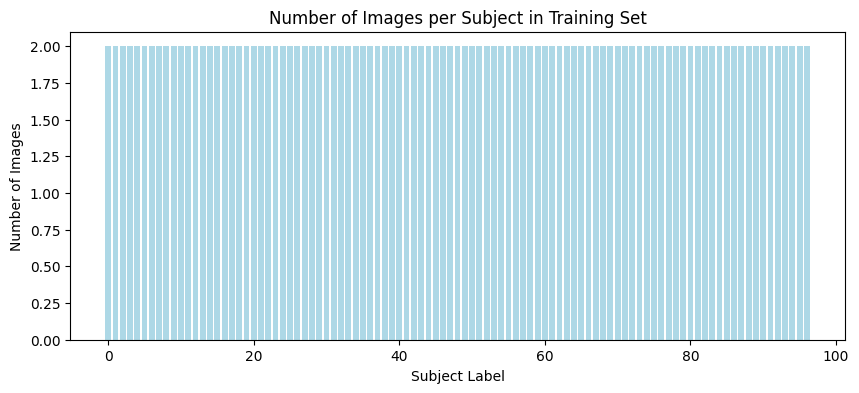

In [68]:
import numpy as np
import matplotlib.pyplot as plt

print("X_train shape:", X_train.shape)  # (N, height, width, channels)
print("y_train shape:", y_train.shape)

print(f"Number of training samples: {X_train.shape[0]}")
print(f"Image size: {X_train.shape[1]} x {X_train.shape[2]}")
print(f"Number of unique subjects: {len(np.unique(y_train))}")

# Unique subjects and counts
unique, counts = np.unique(y_train, return_counts=True)
print("Subjects:", unique)
print("Number of images per subject:", counts)

# Optional: plot number of images per subject
plt.figure(figsize=(10,4))
plt.bar(unique, counts, color='lightblue')
plt.xlabel("Subject Label")
plt.ylabel("Number of Images")
plt.title("Number of Images per Subject in Training Set")
plt.show()


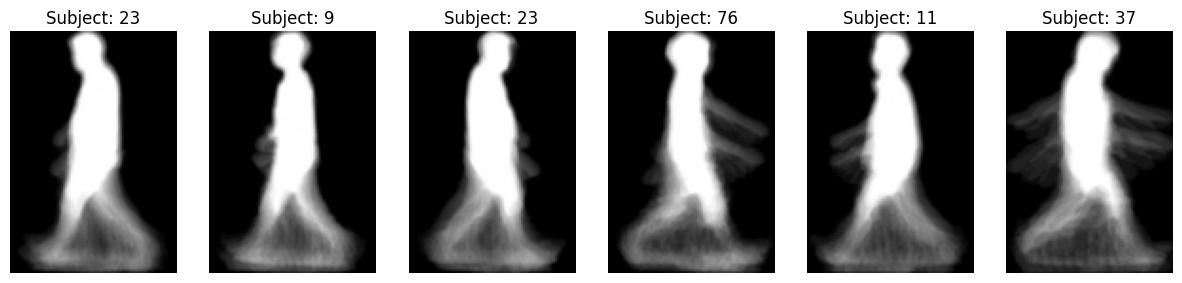

In [69]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_images(X, y, num_samples=6):
    """
    Visualize random samples from preprocessed image array.
    
    Args:
        X (np.array): Image array (N, height, width, 1)
        y (np.array): Labels array (N,)
        num_samples (int): Number of images to display
    """
    indices = np.random.choice(len(X), num_samples, replace=False)
    
    plt.figure(figsize=(15, 4))
    for i, idx in enumerate(indices):
        img = X[idx].squeeze()  # Remove channel dim if any
        label = y[idx]
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Subject: {label}")
        plt.axis('off')
    plt.show()

# Visualize random 6 training images
visualize_images(X_train, y_train, num_samples=6)


In [70]:
import numpy as np

np.save("gei__/X_train.npy", X_train)
np.save("gei__/y_train.npy", y_train)
np.save("gei__/X_test.npy", X_test)
np.save("gei__/y_test.npy", y_test)

print("Preprocessed data saved as X_train.npy, y_train.npy, X_test.npy, y_test.npy")


Preprocessed data saved as X_train.npy, y_train.npy, X_test.npy, y_test.npy


In [78]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
# Since labels start from 0, we can directly use to_categorical
num_classes = len(np.unique(y_train))
print(f"Number of unique classes: {num_classes}")

# One-hot encode training and test labels
y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

print(f"Original y_train shape: {y_train.shape}")
print(f"One-hot y_train shape: {y_train_onehot.shape}")
print(f"Original y_test shape: {y_test.shape}")
print(f"One-hot y_test shape: {y_test_onehot.shape}")

# Show example of one-hot encoding
print(f"\nExample - Original label: {y_train[0]}")
print(f"One-hot encoded: {y_train_onehot[0]}")


Number of unique classes: 97
Original y_train shape: (194,)
One-hot y_train shape: (194, 97)
Original y_test shape: (194,)
One-hot y_test shape: (194, 97)

Example - Original label: 0
One-hot encoded: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


In [101]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_very_simple_cnn(input_shape, num_classes):
    """
    Create a very simple CNN with minimal layers.
    Perfect for small datasets and quick prototyping.
    
    Args:
        input_shape (tuple): Shape of input images (height, width, channels)
        num_classes (int): Number of classes for classification
        
    Returns:
        model: Simple CNN model
    """
    model = Sequential([
        # First Conv Layer
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        
        # Second Conv Layer  
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Flatten and Dense layers
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the simple model
input_shape = X_train.shape[1:]  # (88, 128, 1)
model = create_very_simple_cnn(input_shape, num_classes)

# Show model summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 86, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 41, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     2,457,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 97)             │         6,305 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,482,785 (9.47 MB)

 Trainable params: 2,482,785 (9.47 MB)

 Non-trainable params: 0 (0.00 B)

In [239]:
def create_lenet_style_cnn(input_shape, num_classes):
    """
    LeNet-5 inspired architecture - one of the first successful CNNs.
    Simple and effective for digit/pattern recognition.
    """
    model = Sequential([
        Conv2D(6, (5, 5), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        
        Conv2D(16, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile LeNet-style model
model = create_lenet_style_cnn(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("LeNet-5 Style Model:")
model.summary()


LeNet-5 Style Model:


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_185 (Conv2D)             │ (None, 124, 84, 6)     │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 62, 42, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_186 (Conv2D)             │ (None, 58, 38, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 29, 19, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 8816)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 120)            │     1,058,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 97)             │         8,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,079,021 (4.12 MB)

 Trainable params: 1,079,021 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

In [240]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")


Model compiled successfully!


In [241]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks for better training
callbacks = [
    EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,min_lr=0.00001)
]
# Training parameters
BATCH_SIZE = 32
EPOCHS = 100
print(f"Training configuration:")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")

Training configuration:
Batch size: 32
Epochs: 100


In [242]:
# Train the model
print("Starting model training...")
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")


Starting model training...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.0052 - loss: 4.6089 - val_accuracy: 0.0206 - val_loss: 4.5714 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0103 - loss: 4.5725 - val_accuracy: 0.0258 - val_loss: 4.5727 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0258 - loss: 4.5724 - val_accuracy: 0.0309 - val_loss: 4.5708 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0309 - loss: 4.5683 - val_accuracy: 0.0309 - val_loss: 4.5658 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0258 - loss: 4.5631 - val_accuracy: 0.0309 - val_loss: 4.5604 - learning_rate: 0.0010
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.0464 - loss: 4.5542 - val_accuracy: 0.0412 - val_loss: 4.5513 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0412 - lo

In [243]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_onehot, axis=1)

print(f"Prediction shape: {y_pred.shape}")
print(f"Predicted classes shape: {y_pred_classes.shape}")



Test Results:
Test Loss: 0.9773
Test Accuracy: 0.7784
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction shape: (194, 97)
Predicted classes shape: (194,)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     0.0000    0.0000    0.0000         2
           2     1.0000    1.0000    1.0000         2
           3     1.0000    0.5000    0.6667         2
           4     1.0000    1.0000    1.0000         2
           5     0.0000    0.0000    0.0000         2
           6     1.0000    1.0000    1.0000         2
           7     0.5000    0.5000    0.5000         2
           8     0.6667    1.0000    0.8000         2
           9     1.0000    1.0000    1.0000         2
          10     1.0000    0.5000    0.6667         2
          11     1.0000    1.0000    1.0000         2
          12     1.0000    1.0000    1.0000         2
          13     1.0000    1.0000    1.0000         2
          14     1.0000    1.0000    1.0000         2
          15     1.0000    1.0000    1.0000         2
          16     1.0

d:\vit study\Machine Learning\GEN AI Model\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\vit study\Machine Learning\GEN AI Model\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\vit study\Machine Learning\GEN AI Model\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

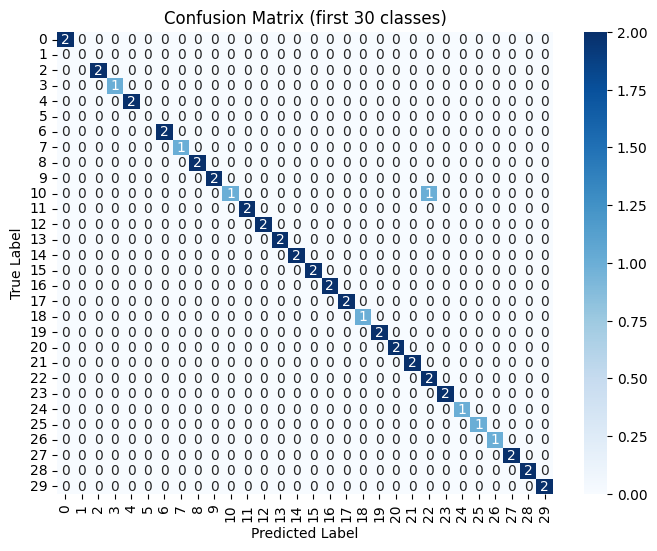

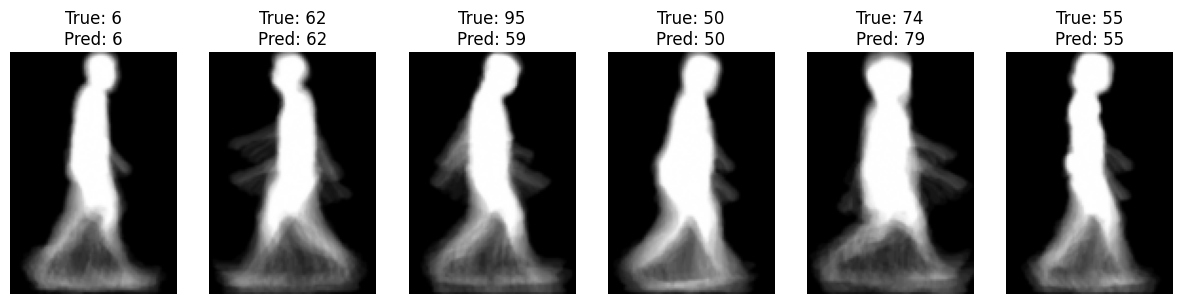

In [251]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Plot Accuracy & Loss Curves
def plot_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r--', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Usage:
# plot_history(history)


# 2. Compare Predicted vs. True Labels

# Get predicted class indices
y_pred_prob = model.predict(X_test)    # or X_test if grayscale hybrid
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Plot confusion matrix for a subset of classes (e.g., first 10)
num_display = 30
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm[:num_display, :num_display], 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"{i}" for i in range(num_display)],
            yticklabels=[f"{i}" for i in range(num_display)])
plt.title(f'Confusion Matrix (first {num_display} classes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 3. Display Sample Predictions vs. True Labels

def display_samples(X, y_true, y_pred, num_samples=6):
    """
    Show num_samples random test images with true vs predicted labels.
    """
    idxs = np.random.choice(len(X), num_samples, replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(idxs):
        img = X[idx]
        if img.ndim == 3 and img.shape[2] == 3:
            plt_img = img
        else:  # single channel
            plt_img = img.squeeze()
        plt.subplot(1, num_samples, i+1)
        plt.imshow(plt_img, cmap='gray' if plt_img.ndim==2 else None)
        plt.title(f"True: {y_true[idx]}\nPred: {y_pred[idx]}")
        plt.axis('off')
    plt.show()

# Usage:
display_samples(X_test, y_true, y_pred, num_samples=6)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


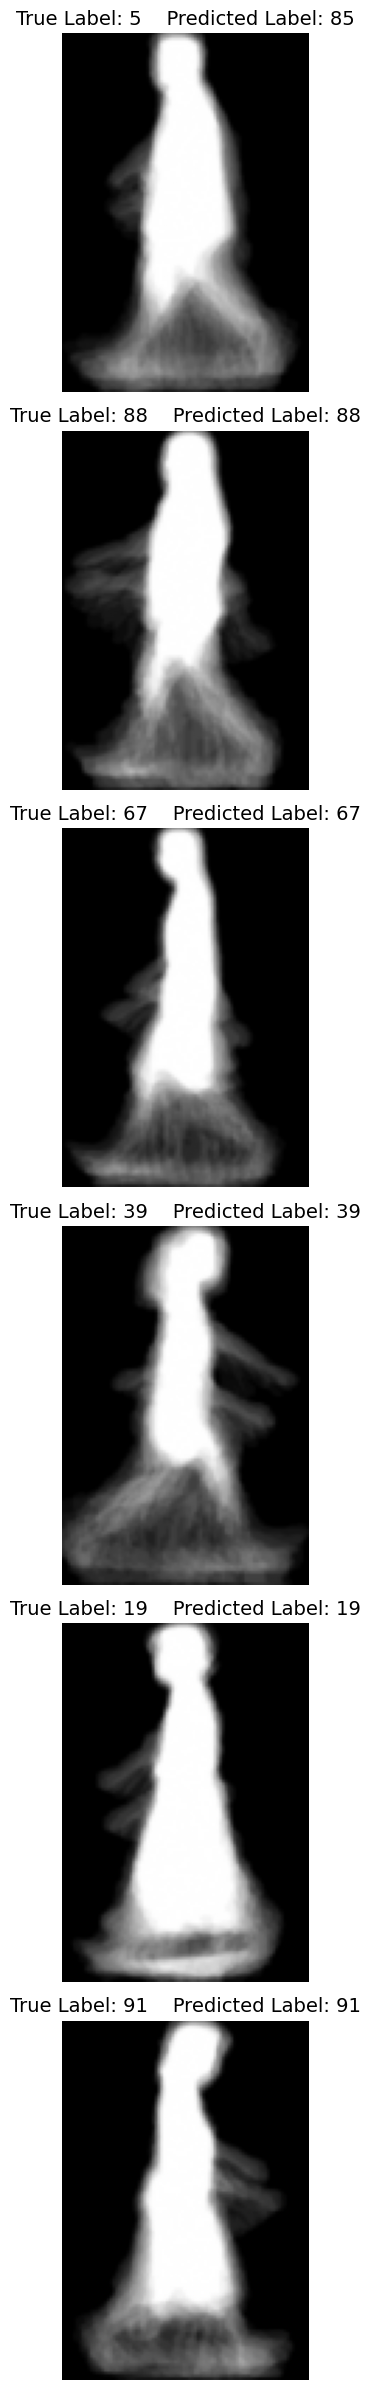

In [248]:
import matplotlib.pyplot as plt
import numpy as np

def display_image_with_label_comparison(X, y_true, y_pred, num_samples=6):
    """
    Display images side by side with their true and predicted labels below.
    
    Args:
        X (np.array): Test images array, shape (N, H, W, C) or (N, H, W).
        y_true (list or np.array): True class indices.
        y_pred (list or np.array): Predicted class indices.
        num_samples (int): Number of random samples to display.
    """
    # Select random sample indices
    idxs = np.random.choice(len(X), num_samples, replace=False)
    
    plt.figure(figsize=(12, 4 * num_samples))
    for i, idx in enumerate(idxs):
        img = X[idx]
        # Prepare image for display
        if img.ndim == 3 and img.shape[2] == 1:
            disp_img = img.squeeze()
            cmap = 'gray'
        elif img.ndim == 3 and img.shape[2] == 3:
            disp_img = img.astype('uint8')
            cmap = None
        else:
            disp_img = img
            cmap = 'gray'
        
        # Display the image
        ax = plt.subplot(num_samples, 1, i + 1)
        plt.imshow(disp_img, cmap=cmap)
        plt.axis('off')
        
        # Annotate with true vs predicted label
        true_label = y_true[idx]
        pred_label = y_pred[idx]
        plt.title(f"True Label: {true_label}    Predicted Label: {pred_label}", fontsize=14)
    
    plt.tight_layout()
    plt.show()

# Example usage:
y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_test_onehot, axis=1)
display_image_with_label_comparison(X_test, y_true_classes, y_pred_classes, num_samples=6)
